In [304]:
from transparent_background import Remover

In [305]:
remover = Remover(fast=True, device="cpu")

Settings -> Mode=fast, Device=cpu, Torchscript=disabled


In [2]:
from PIL import Image
import cv2
import numpy as np

img = Image.open("./test_img/test5.jpg")

In [307]:
mask = remover.process(img, type="map")

In [308]:
import matplotlib.pyplot as plt

def visualize_mask(img, mask):
    if len(mask.shape) == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    img_np = np.array(img)
    new = cv2.bitwise_and(img_np, mask)
    mask_pil = Image.fromarray(new)
    plt.imshow(mask_pil)
    plt.axis("off")
    plt.show()

def visualize_noise(img, mask):
    if len(mask.shape) == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    img_np = np.array(img)
    new = cv2.bitwise_and(img_np, mask*100)
    mask_pil = Image.fromarray(new)
    plt.imshow(mask_pil)
    plt.axis("off")
    plt.show()

def visualize_green(img, mask):
    if len(mask.shape) == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    bg = ((1- mask/255.0)*[120,255,155]).astype(np.uint8)
    temp = (np.array(img)*(mask/255.0)).astype(np.uint8)
    mask_pil = Image.fromarray(bg + temp)
    plt.imshow(mask_pil)
    plt.axis("off")
    plt.show()

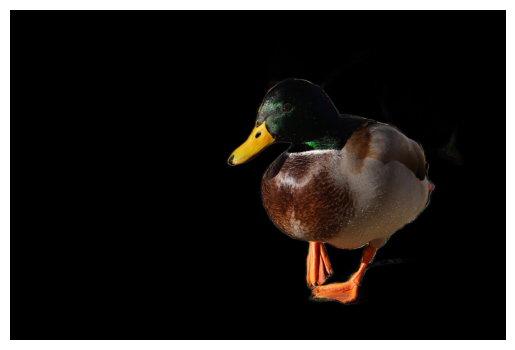

In [309]:
visualize_mask(img, mask)

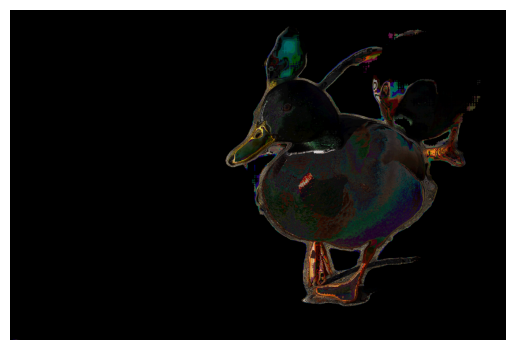

In [310]:
visualize_noise(img, mask)

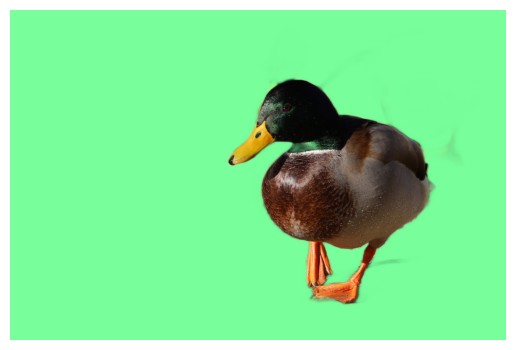

In [311]:
visualize_green(img, mask)

In [312]:
kernel_size = max(3, min(mask.shape[0]//256, mask.shape[1]//256))
erode_mask = cv2.erode(mask, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)
dia_mask = cv2.dilate(erode_mask, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)

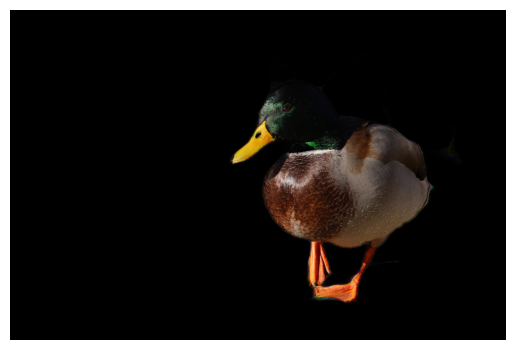

In [313]:
visualize_mask(img, erode_mask)

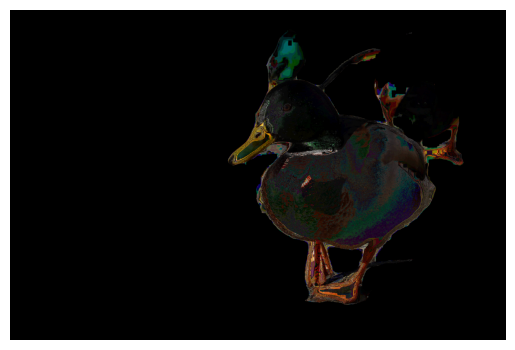

In [314]:
visualize_noise(img, erode_mask)

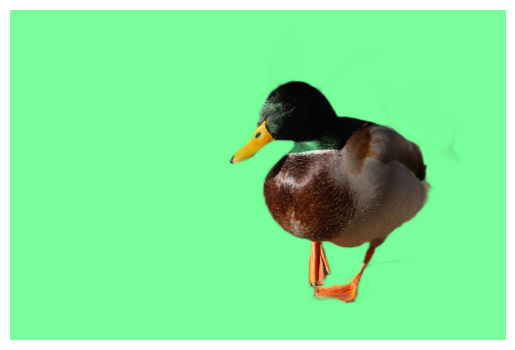

In [315]:
visualize_green(img, erode_mask)

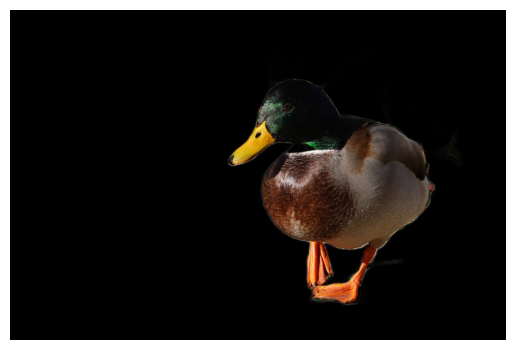

In [316]:
visualize_mask(img, dia_mask)

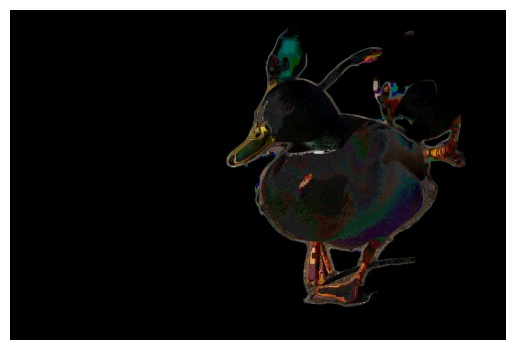

In [317]:
visualize_noise(img, dia_mask)

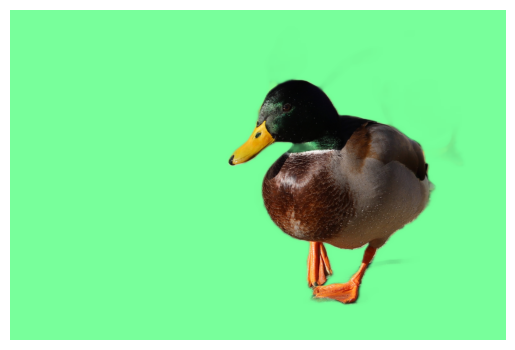

In [318]:
visualize_green(img, dia_mask)

In [319]:
threshhold = 200
mask_thresh = np.where(mask > threshhold, mask, 0)

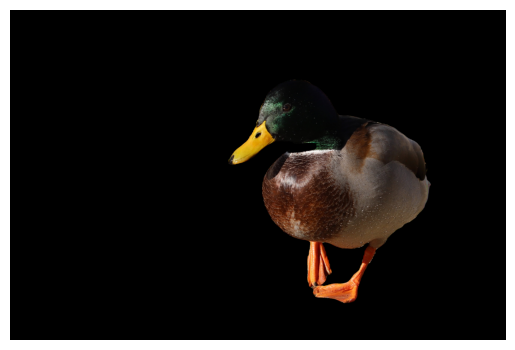

In [320]:
visualize_mask(img, mask_thresh)

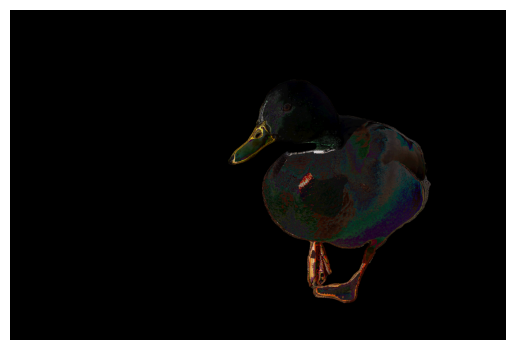

In [321]:
visualize_noise(img, mask_thresh)

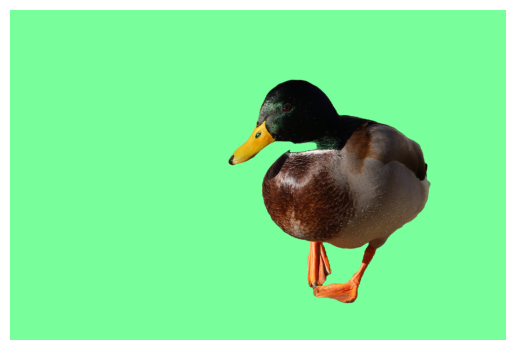

In [322]:
visualize_green(img, mask_thresh)

In [323]:
def mask_sigmoid(x, exp=2.7, value_range=255.0, offset=135):
    x = x.astype(np.float64)

    y = 1/(1+exp**(offset-x))*value_range

    return y.astype(np.uint8)

mask_sig = mask_sigmoid(mask, exp=1.06, value_range=255.0)


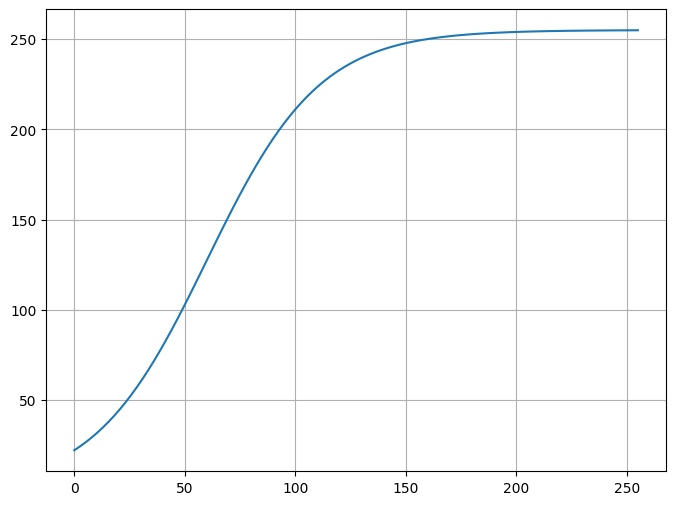

In [5]:
import matplotlib.pyplot as plt

def visualize_fuction(func):
    x = np.linspace(0,255,100)
    y = func(x)

    plt.figure(figsize=(8,6))
    plt.plot(x,y)
    plt.grid(True)
    plt.show()

def sigmoid(x):
    return 1/(1+1.04**(60-x))*255

visualize_fuction(sigmoid)

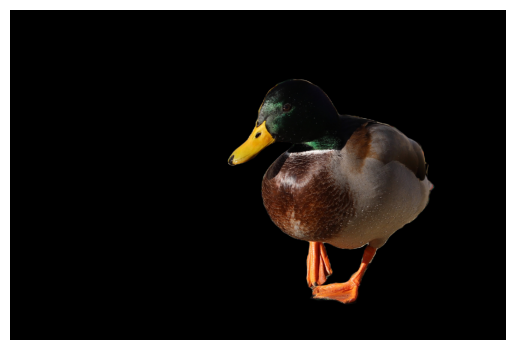

In [325]:
visualize_mask(img, mask_sig)

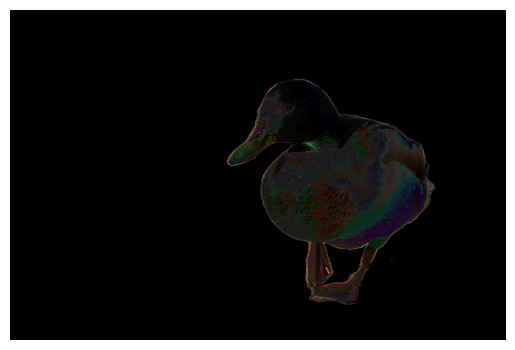

In [326]:
visualize_noise(img, mask_sig)

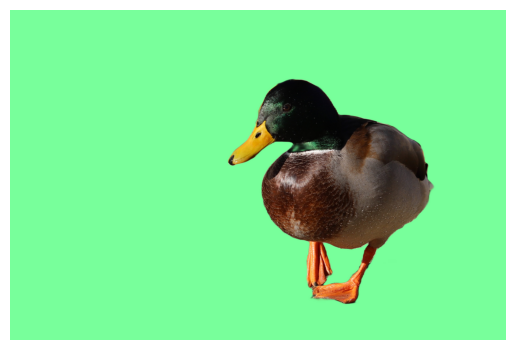

In [327]:
visualize_green(img, mask_sig)

In [328]:
kernel_size = max(3, min(mask.shape[0]//256, mask.shape[1]//256))
erode_mask = cv2.erode(mask_sig, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)
dia_mask = cv2.dilate(erode_mask, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)

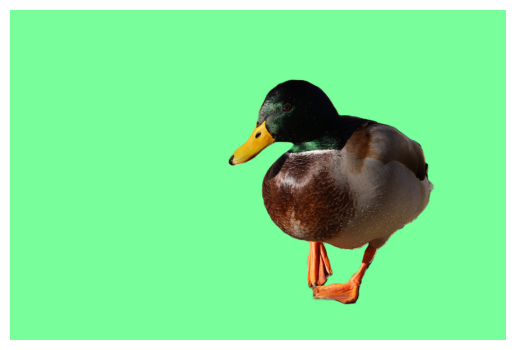

In [329]:
visualize_green(img, dia_mask)

In [330]:
mask_sig2 = mask_sigmoid(mask, exp=1.06, value_range=255.0, offset=80)

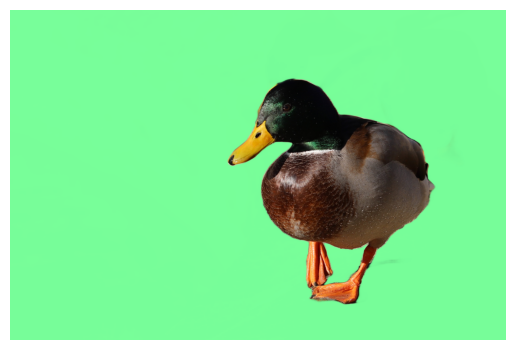

In [331]:
visualize_green(img, mask_sig2)

In [332]:
mask_process = cv2.cvtColor(mask_sig, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(mask_process, 100, 200)

In [333]:
edge_mask = np.zeros_like(mask_process)
contours, hierarchy = cv2.findContours(mask_process, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(edge_mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

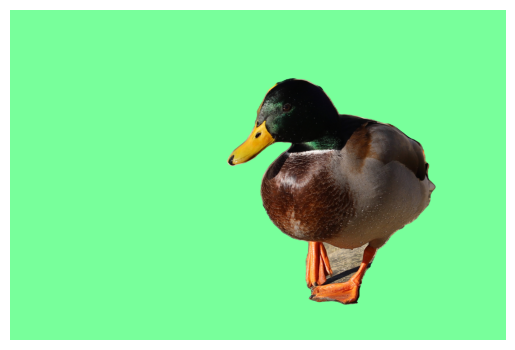

In [334]:
visualize_green(img, edge_mask)

In [335]:
mask_sig3 = mask_sigmoid(mask_sig, exp=1.06, value_range=255.0, offset=60)

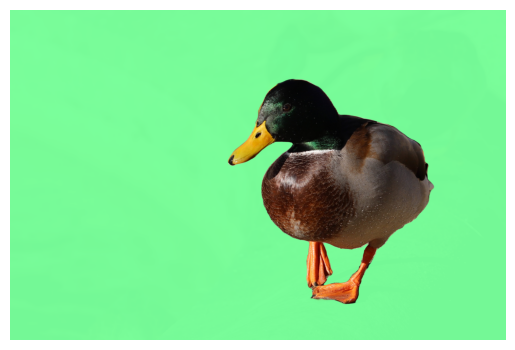

In [336]:
visualize_green(img, mask_sig3)

In [340]:
def custom_process(mask):
    
    if len(mask.shape) != 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    mask_sig_bg = mask_sigmoid(mask, exp=1.2, value_range=255.0, offset=135)    
    mask_sig_obj = mask_sigmoid(mask, exp=1.06, value_range=255.0, offset=60)

    contour_mask = np.zeros_like(mask_sig_bg)
    contours, _ = cv2.findContours(mask_sig_bg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(contour_mask, [largest_contour], -1, 1, thickness=cv2.FILLED)
    
    kernel_size = max(3, min(mask.shape[0]//256, mask.shape[1]//256))

    contour_mask = cv2.erode(contour_mask, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)
    mask_sig_contour = np.where(contour_mask == 1, mask_sig_obj, mask_sig_bg)

    erode_mask = cv2.erode(mask_sig_contour, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)
    dia_mask = cv2.dilate(erode_mask, np.ones((kernel_size,kernel_size),np.uint8), iterations=3)
    
    return dia_mask


In [341]:
custom_mask = custom_process(mask)

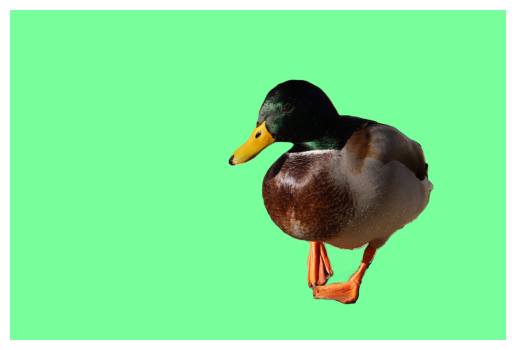

In [342]:
visualize_green(img, custom_mask)